In [1]:
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

In [2]:
folders = [x[0] for x in os.walk('images')][1:]

In [3]:
images = []
for folder in folders:
    with open(folder+'\\filelist_LBP.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for img_name, left, top, right, bottom, new_size_y, new_size_x in reader:
            img = Image.open(folder+'\\'+img_name).resize((int(new_size_y), int(new_size_x))).crop((int(left), int(top), int(right), int(bottom))).resize((100,100))
            images.append(img)

Showing few random faces from the dataset.

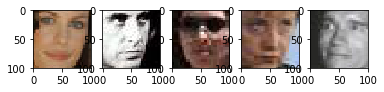

In [4]:
num_faces = 5

for i in range(1, num_faces+1):
    img = random.choice(images)
    plt.subplot(2, num_faces, i)
    plt.imshow(img)

In [5]:
len(images)

14233

Some images in the data set are in greyscale. 

17 images are in grey scale

Random image from the set to show


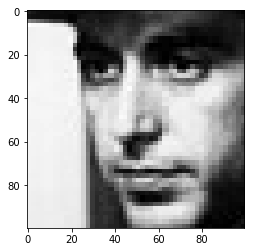

In [6]:
images_in_grey_scale = [i for i in range(len(images)) if np.array(images[i]).shape==(100, 100)]
print("{} images are in grey scale\n".format(len(images_in_grey_scale)))
print("Random image from the set to show")
grey_img = images[random.choice(images_in_grey_scale)]
plt.imshow(grey_img, cmap='gray')

Convert greyscale to RGB

In [7]:
grey_img.size

(100, 100)

In [8]:
from collections import defaultdict
import pprint

for i in images_in_grey_scale:
    temp = images[i] 
    images[i] = Image.new("RGB", grey_img.size)
    images[i].paste(temp)

### Implementing eigenfaces with SVD

Implement eigenfaces using singular value decomposition (SVD). Remember to represent the images properly and account for the color.

First I will resize images to improve perfromance and not encounter Memory Error.

In [9]:
# resize images
basewidth = 30

img = images[0]
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))

n_images = len(images)
original_shape = np.array(images[0]).shape

small_images = np.empty((n_images,basewidth,hsize,original_shape[-1]))

for i in range(n_images):
    small_images[i] = images[i].resize((basewidth,hsize),Image.ANTIALIAS)


In [10]:
# =============== TODO: Your code here ===============
# Represent the images as a matrix for SVD decompotision.

# record the original shape

small_shape = (basewidth, basewidth, original_shape[-1])
flat_len = basewidth*basewidth*original_shape[-1]
arr = np.empty((n_images,flat_len), int)

for i in range(n_images):
    # make a 1-dimensional view of arr
    flat_arr = np.array(small_images[i]).ravel()
    # convert it to a matrix
    vector = np.matrix(flat_arr) 
    arr[i] = vector

# ====================================================

I wanted to take a look on averge image :)

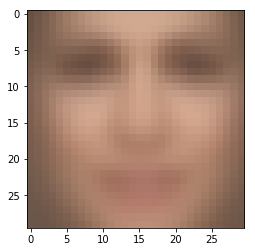

In [11]:
avg_image = np.mean(arr, axis=0)
plt.imshow(np.array(avg_image, dtype='uint8').reshape(small_shape))

In [14]:
# =============== TODO: Your code here ===============
# Implement eigenfaces using singular value decomposition (SVD). 
# Remember to represent the images properly and account for the color.
from sklearn.decomposition import TruncatedSVD
num_eigfaces = 10

arr_standardized = arr - avg_image
C = np.cov(arr_standardized.T)

svd = TruncatedSVD(n_components = num_eigfaces)
svd.fit(C)
# need to multiply on 255 as currently components are normalized and thus in range (0,1)
components = svd.components_ * 255 
# ====================================================

Visualize 10 eigenfaces associated with the highest eigenvalues.

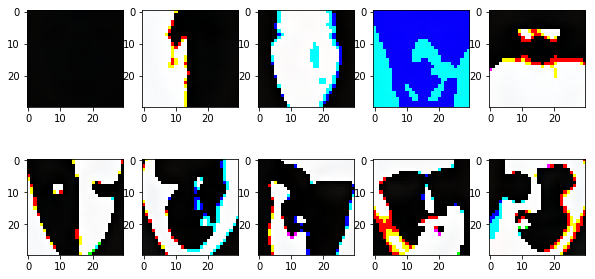

In [15]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces associated with the highest eigenvalues.
from matplotlib import rcParams
rcParams['figure.figsize'] = [10, 5]

for i in range(1, num_eigfaces+1):
    eigface = np.array(components[i-1], dtype='uint8').reshape(small_shape)
    plt.subplot(2, num_eigfaces//2, i)
    plt.imshow(eigface)

# ====================================================

For Eigenfaces we actually don't need to find the covariance matrix, we can find the SVD of just standardized data matrix as SVD finds the covariance matrix of input be definition of the method. Whereas the eigenfaces obtained with SVD on covariance matrix are closer to ones found with iterative PCA, so me main result is the one above.  
Just to confirm the idea of similarity of eigenvectors for covariance matrix and standardized data matrix, let's look at eigenfaces found with SVD on data matrix:

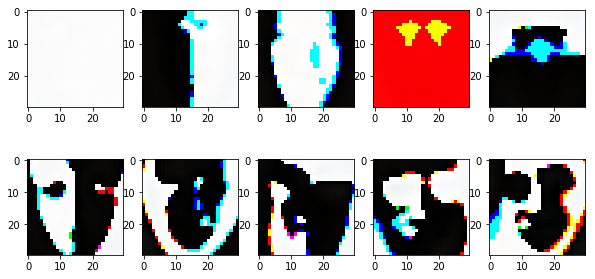

In [16]:
svd = TruncatedSVD(n_components = num_eigfaces)
svd.fit(arr_standardized)
# need to multiply on 255 as currently components are normalized and thus in range (0,1)
components = svd.components_ * 255 
for i in range(1, num_eigfaces+1):
    eigface = np.array(components[i-1], dtype='uint8').reshape(small_shape)
    plt.subplot(2, num_eigfaces//2, i)
    plt.imshow(eigface)

### Implementing eigenfaces with variance maximization

As you have noticed, SVD could be quite slow if the number of faces is large. If the number of faces exceeds 50k, which is not a large dataset according to the modern standards, doing SVD is not possible directly and you have to use iterative methods for computing eigenfaces.

Here, you are going to calculate 10 eigenfaces by maximizing variance as stated in the lecture notes.

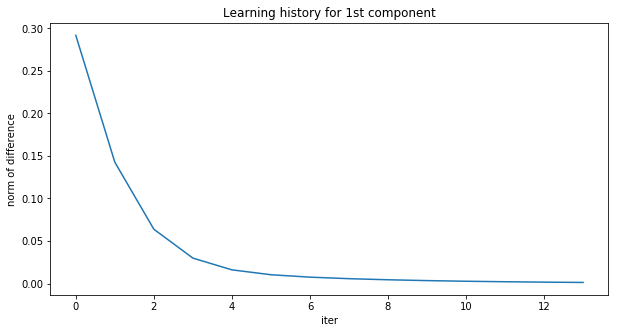

Components found with SVD
 [[-5.64243044 -5.0134587  -4.40073788 ... -3.49137744 -3.29792216
  -3.04729031]
 [ 5.22683439  4.18283575  3.36211474 ... -5.05088619 -4.08580929
  -3.40949309]
 [ 8.34604567  7.42786786  6.4146216  ... 11.04542553  9.340148
   7.83044681]
 ...
 [ 6.52310428  5.8095331   5.55268317 ... -8.47998462 -8.81275327
  -8.33160101]
 [ 5.43872019  4.06094712  2.95158111 ... -3.19609042 -2.25483199
  -2.09078686]
 [ 9.75587295  7.74729535  6.1335255  ... 14.08313663 15.06317543
  14.70347659]]

Components found iteratively
 [[  5.62379415   4.99853989   4.3887246  ...   3.50914798   3.31228919
    3.05927381]
 [ -5.24740676  -4.20382307  -3.38171625 ...   5.03644461   4.0717782
    3.39671008]
 [ -8.32945821  -7.43140986  -6.43160841 ... -11.03371594  -9.34683196
   -7.84938063]
 ...
 [ -6.63933372  -5.89207463  -5.60679341 ...   8.730523     9.01039129
    8.50692988]
 [ -4.61981567  -3.39837437  -2.41233259 ...   3.76424714   2.91432128
    2.75410251]
 [ 10.4391615

In [17]:
# =============== TODO: Your code here ===============
# Calculate 10 eigenfaces iteratively by variance maximization.

std = np.std(arr_standardized)
arr_normalized = arr_standardized/std
v = np.dot(arr_normalized.T, arr_normalized)/n_images

def normalize(x):
    return x/np.linalg.norm(x)

# w0 = np.zeros(arr_normalized.shape[1])/2

hist = []

# find a primncipal component
def find_iter_component(v):
    stop = False
    epsilon = 1e-3
    alpha = 1e-3
    w = np.random.sample(v.shape[0])
    w = normalize(w)
    while True:
        # unward gradient to find w (maximize)
        w_prev = w.copy()
        w += alpha * 2 * v.dot(w)
        w = normalize(w)
        diff_norm = np.linalg.norm(w_prev-w)
        if diff_norm < epsilon:
            return w
        hist.append(diff_norm)

components_iter = []
components_iter.append(find_iter_component(v))

plt.plot(hist) 
plt.title("Learning history for 1st component")
plt.xlabel("iter")
plt.ylabel("norm of difference")
plt.show()

data_initial = arr

# find all the rest of principal components
for i in range(9):
    sum_ = 0
    for j in range(i+1):
        sum_ += np.outer(np.dot(data_initial, components_iter[j]),components_iter[j])
    data_projected = data_initial - sum_
    standardized = data_projected - np.mean(data_projected, axis=0)
    normalized = standardized/np.std(standardized)
    var_projected = np.dot(normalized.T, normalized)/n_images
    components_iter.append(find_iter_component(var_projected))


components_iter = np.array(components_iter)*255
print("Components found with SVD\n", components)
print("\nComponents found iteratively\n", components_iter)
    
# ====================================================

Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces. 

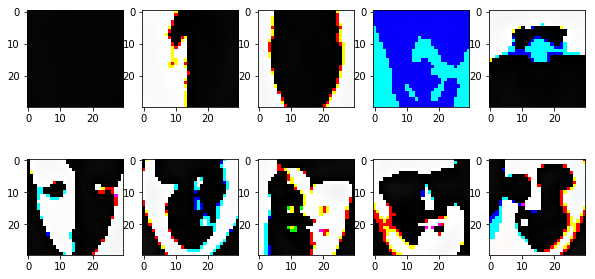

In [18]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces.
# for i in range(1, num_eigfaces+1):
for i in range(1, len(components_iter)+1):
    eigface = np.array(components_iter[i-1], dtype='uint8').reshape(small_shape)
    plt.subplot(2, num_eigfaces//2, i)
    plt.imshow(eigface)

# ====================================================

The eigenfaces found with iterative PCA look similar to ones found using SVD but don't match strictly (the difference in principal components is up to 0.1).